In [1]:
#!/usr/bin/env python3
"""
compare_wave_load.py

This script compares the QTF matrices computed by the NumPy-based, PyTorch-based, and JAX-based
wave load implementations. It initializes all versions with the same wave
parameters and vessel configuration, extracts the QTF matrices, computes the
difference, and then displays basic statistics along with plots for a visual
comparison of a representative slice.
"""

import numpy as np
import matplotlib.pyplot as plt
import json
import time
import math
# Ensure the x-axis data matches the shape of the y-axis data
# Interpolate qtf_angles_deg to match the shape of the RAO amplitude arrays
from scipy.interpolate import interp1d

# --- Import the NumPy version of wave load ---
from mclsimpy.waves import WaveLoad as NumpyWaveLoad

# --- Import the PyTorch version of wave load ---
import torch
from torch_core.simulator.waves.wave_load_torch import WaveLoad as TorchWaveLoad

# --- Import the JAX version of wave load and required packages ---
import jax
import jax.numpy as jnp
from jax_core.simulator.waves.wave_load_jax_jit import init_wave_load as init_jax_wave_load
from jax_core.simulator.waves.wave_load_jax_jit import first_order_loads as jax_first_order_loads 
from jax_core.simulator.waves.wave_load_jax_jit import second_order_loads as jax_second_order_loads
from jax_core.simulator.waves.wave_load_jax_jit import wave_load as jax_wave_load
from jax_core.simulator.waves.wave_load_jax_jit import relative_incident_angle as jax_relative_incident_angle
from jax_core.simulator.waves.wave_load_jax_jit import rao_interp as jax_rao_interp

In [2]:

# ------------------------------
# Set up identical wave parameters
# ------------------------------

# Simulation parameters for wave properties
hs    = 5.0 / 90.0  # Significant wave height [m]
tp    = 17.0 * math.sqrt(1 / 90.0)  # Peak period [s]
gamma = 3.3  # JONSWAP peak factor

wp   = 2 * math.pi / tp   # Peak frequency [rad/s]
wmin = 0.5 * wp
wmax = 3.0 * wp
N    = 100             # Number of wave components

# Generate frequency arrays for NumPy, JAX, and PyTorch
freqs_np = np.linspace(wmin, wmax, N)
freqs_jax = jnp.linspace(wmin, wmax, N)
freqs_torch = torch.linspace(wmin, wmax, N)

# Dummy wave spectrum data is used (actual spectrum not needed for QTF interpolation)
dw = (wmax - wmin) / N
# Using a dummy spectrum (ones) so that the wave amplitudes are computed similarly;
# note: the QTF computation does not use the amplitudes.
wave_spectrum_np = np.ones(N)
wave_spectrum_jax = jnp.ones(N)
wave_spectrum_torch = torch.ones(N)
wave_amps_np = np.sqrt(2.0 * wave_spectrum_np * dw)
wave_amps_jax = jnp.sqrt(2.0 * wave_spectrum_jax * dw)
wave_amps_torch = torch.sqrt(2.0 * wave_spectrum_torch * dw)

# Fixed phases (linearly spaced) for reproducible results 
# NBNBNB!! not random and not how one would do it normally 
# it should be random.uniform(0, 2*np.pi, N)
rand_phase_np = np.linspace(0, 2 * np.pi, N)
rand_phase_jax = jnp.linspace(0, 2 * jnp.pi, N)
rand_phase_torch = torch.linspace(0, 2 * np.pi, N)

# Constant incident wave angles (e.g. 45°)
wave_angles_np = np.ones(N) * (np.pi / 4)
wave_angles_jax = jnp.ones(N) * (jnp.pi / 4)
wave_angles_torch = torch.ones(N) * (np.pi / 4)

# Configuration file path (update this path as needed)
config_file = "/home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/mclsimpy/vessel_data/CSAD/vessel_json.json"  # Ensure this file exists and is compatible with both versions


=== Comparing Wave Numbers (k) with deep_water = False ===
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
NumPy-based (shallow) wave load init time: 0.19 seconds
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
JAX-based (shallow) wave load init time: 4.92 seconds
PyTorch-based (shallow) wave load init time: 0.39 seconds
Wave Number (k) shapes:
  NumPy: (100,)
  JAX: (100,)
  PyTorch: (100,)
Max absolute difference in k (NumPy vs JAX): 1.806646098501119e-06
Max absolute difference in k (NumPy vs PyTorch): 1.614939755256728e-06
Mean absolute difference in k (NumPy vs JAX): 3.023092231063673e-07
Mean absolute difference in k (NumPy vs PyTorch): 3.4116195264

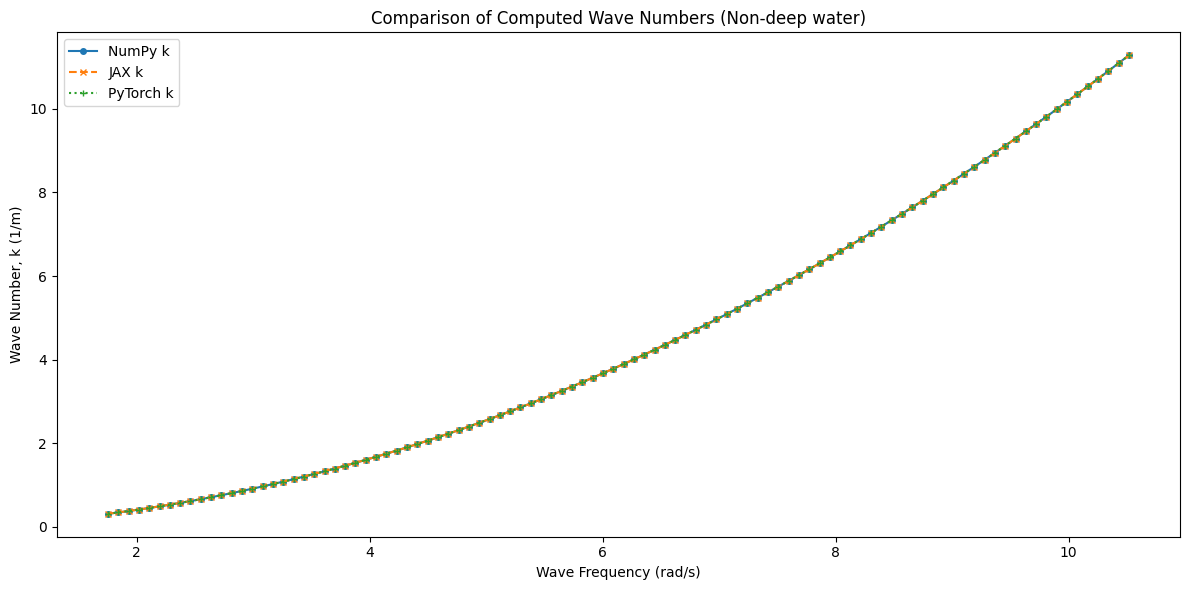

In [3]:

# =============================================================================
# Compare Wave Numbers (k) for non-deep water (iterative scheme)
# =============================================================================
print("\n=== Comparing Wave Numbers (k) with deep_water = False ===")

# Initialize NumPy-based WaveLoad with deep_water=False.
start_time = time.time()
numpy_wl_shallow = NumpyWaveLoad(
    wave_amps=wave_amps_np,
    freqs=freqs_np,
    eps=rand_phase_np,
    angles=wave_angles_np,
    config_file=config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=False  # Force iterative wave number calculation
)
print(f"NumPy-based (shallow) wave load init time: {time.time() - start_time:.2f} seconds")

# Initialize JAX-based WaveLoad with deep_water=False.
start_time = time.time()
jax_wl_shallow = init_jax_wave_load(
    wave_amps=wave_amps_jax,
    freqs=freqs_jax,
    eps=rand_phase_jax,
    angles=wave_angles_jax,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=False,  # Force iterative scheme
    qtf_method="Newman",
    qtf_interp_angles=True,
    interpolate=True
)
print(f"JAX-based (shallow) wave load init time: {time.time() - start_time:.2f} seconds")

# Initialize the Pytorch-based WaveLoad with deep_water=False.
start_time = time.time()
torch_wl_shallow = TorchWaveLoad(
    wave_amps=wave_amps_torch,
    freqs=freqs_torch,
    eps=rand_phase_torch,
    angles=wave_angles_torch,
    config_file=config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=False  # Force iterative wave number calculation
)
print(f"PyTorch-based (shallow) wave load init time: {time.time() - start_time:.2f} seconds")


# In each implementation the wave number, k, is computed during initialization.
# For NumPy, it is stored as _k and for JAX as the field k.
k_numpy = numpy_wl_shallow._k    # NumPy array
k_jax = np.array(jax_wl_shallow.k) # Convert JAX array to NumPy
k_torch = torch_wl_shallow._k.detach().cpu().numpy()  # Convert PyTorch tensor to NumPy array

print("Wave Number (k) shapes:")
print("  NumPy:", k_numpy.shape)
print("  JAX:", k_jax.shape)
print("  PyTorch:", k_torch.shape)

# Compare the wave number arrays:
k_diff_jax = np.abs(k_numpy - k_jax)
k_diff_torch = np.abs(k_numpy - k_torch)
print("Max absolute difference in k (NumPy vs JAX):", np.max(k_diff_jax))
print("Max absolute difference in k (NumPy vs PyTorch):", np.max(k_diff_torch))
print("Mean absolute difference in k (NumPy vs JAX):", np.mean(k_diff_jax))
print("Mean absolute difference in k (NumPy vs PyTorch):", np.mean(k_diff_torch))

# Plot the wave numbers for visual inspection.
plt.figure(figsize=(12, 6))
plt.plot(freqs_np, k_numpy, label="NumPy k", marker="o", linestyle="-", markersize=4)
plt.plot(freqs_np, k_jax, label="JAX k", marker="x", linestyle="--", markersize=4)
plt.plot(freqs_np, k_torch, label="PyTorch k", marker="+", linestyle=":", markersize=4)
plt.xlabel("Wave Frequency (rad/s)")
plt.ylabel("Wave Number, k (1/m)")
plt.title("Comparison of Computed Wave Numbers (Non-deep water)")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# ------------------------------
# Initialize WaveLoad objects from all implementations (Deep Water)
# ------------------------------

# Create NumPy-based wave load instance (geo-mean)
start_time = time.time()
numpy_wl_geo = NumpyWaveLoad(
    wave_amps=wave_amps_np,
    freqs=freqs_np,
    eps=rand_phase_np,
    angles=wave_angles_np,
    config_file=config_file,
    interpolate=True,
    qtf_method="geo-mean",
    deep_water=True
)
print(f"NumPy-based wave load (geo-mean) init time: {time.time() - start_time:.2f} seconds")

# Create JAX-based wave load instance (geo-mean)
start_time = time.time()
jax_wl_geo = init_jax_wave_load(
    wave_amps=wave_amps_jax,
    freqs=freqs_jax,
    eps=rand_phase_jax,
    angles=wave_angles_jax,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=True,
    qtf_method="geo-mean",
    qtf_interp_angles=True,
    interpolate=True
)
print(f"JAX-based wave load (geo-mean) init time: {time.time() - start_time:.2f} seconds")

# Create PyTorch-based wave load instance (geo-mean)
start_time = time.time()
torch_wl_geo = TorchWaveLoad(
    wave_amps=wave_amps_torch,
    freqs=freqs_torch,
    eps=rand_phase_torch,
    angles=wave_angles_torch,
    config_file=config_file,
    interpolate=True,
    qtf_method="geo-mean",
    deep_water=True
)
print(f"PyTorch-based wave load (geo-mean) init time: {time.time() - start_time:.2f} seconds")

# Create NumPy-based wave load instance (Newman)
start_time = time.time()
numpy_wl_newman = NumpyWaveLoad(
    wave_amps=wave_amps_np,
    freqs=freqs_np,
    eps=rand_phase_np,
    angles=wave_angles_np,
    config_file=config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=True
)
print(f"NumPy-based wave load (Newman) init time: {time.time() - start_time:.2f} seconds")

# Create JAX-based wave load instance (Newman)
start_time = time.time()
jax_wl_newman = init_jax_wave_load(
    wave_amps=wave_amps_jax,
    freqs=freqs_jax,
    eps=rand_phase_jax,
    angles=wave_angles_jax,
    config_file=config_file,
    rho=1025,
    g=9.81,
    dof=6,
    depth=100,
    deep_water=True,
    qtf_method="Newman",
    qtf_interp_angles=True,
    interpolate=True
)
print(f"JAX-based wave load (Newman) init time: {time.time() - start_time:.2f} seconds")

# Create PyTorch-based wave load instance (Newman)
start_time = time.time()
torch_wl_newman = TorchWaveLoad(
    wave_amps=wave_amps_torch,
    freqs=freqs_torch,
    eps=rand_phase_torch,
    angles=wave_angles_torch,
    config_file=config_file,
    interpolate=True,
    qtf_method="Newman",
    deep_water=True
)
print(f"PyTorch-based wave load (Newman) init time: {time.time() - start_time:.2f} seconds")

***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************
NumPy-based wave load (geo-mean) init time: 0.29 seconds
***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************
JAX-based wave load (geo-mean) init time: 2.08 seconds
PyTorch-based wave load (geo-mean) init time: 0.58 seconds
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
NumPy-based wave load (Newman) init time: 0.39 seconds
***************************************Generate QTF matrices****************************************
Using New

In [5]:
# ------------------------------
# Extract the QTF matrices for comparison
# ------------------------------

# --- Geo-mean method ---
qtf_np_geo = numpy_wl_geo._Q  # Expected shape: (6, M, N, N) where M is number of QTF interpolation angles
qtf_jax_geo = np.array(jax_wl_geo.Q)
qtf_torch_geo = torch_wl_geo._Q.detach().cpu().numpy()  # Convert PyTorch tensor to NumPy array

print("--- Geo-mean QTF Shapes ---")
print("NumPy QTF shape:", qtf_np_geo.shape)
print("JAX QTF shape:", qtf_jax_geo.shape)
print("PyTorch QTF shape:", qtf_torch_geo.shape)

# --- Newman method ---
qtf_np_newman = numpy_wl_newman._Q
qtf_jax_newman = np.array(jax_wl_newman.Q)
qtf_torch_newman = torch_wl_newman._Q.detach().cpu().numpy()

print("\n--- Newman QTF Shapes ---")
print("NumPy QTF shape:", qtf_np_newman.shape)
print("JAX QTF shape:", qtf_jax_newman.shape)
print("PyTorch QTF shape:", qtf_torch_newman.shape)

--- Geo-mean QTF Shapes ---
NumPy QTF shape: (6, 360, 100, 100)
JAX QTF shape: (6, 360, 100, 100)
PyTorch QTF shape: (6, 360, 100, 100)

--- Newman QTF Shapes ---
NumPy QTF shape: (6, 360, 100, 100)
JAX QTF shape: (6, 360, 100, 100)
PyTorch QTF shape: (6, 360, 100, 100)


In [6]:
# ------------------------------
# Compute difference statistics between the QTF matrices
# ------------------------------

# --- Geo-mean method ---
diff_geo_jax = np.abs(qtf_np_geo - qtf_jax_geo)
max_diff_geo_jax = np.max(diff_geo_jax)
mean_diff_geo_jax = np.mean(diff_geo_jax)
print("--- Geo-mean QTF Differences ---")
print("Max absolute difference (NumPy vs JAX):", max_diff_geo_jax)
print("Mean absolute difference (NumPy vs JAX):", mean_diff_geo_jax)

diff_geo_torch = np.abs(qtf_np_geo - qtf_torch_geo)
max_diff_geo_torch = np.max(diff_geo_torch)
mean_diff_geo_torch = np.mean(diff_geo_torch)
print("Max absolute difference (NumPy vs PyTorch):", max_diff_geo_torch)
print("Mean absolute difference (NumPy vs PyTorch):", mean_diff_geo_torch)

# --- Newman method ---
diff_newman_jax = np.abs(qtf_np_newman - qtf_jax_newman)
max_diff_newman_jax = np.max(diff_newman_jax)
mean_diff_newman_jax = np.mean(diff_newman_jax)
print("\n--- Newman QTF Differences ---")
print("Max absolute difference (NumPy vs JAX):", max_diff_newman_jax)
print("Mean absolute difference (NumPy vs JAX):", mean_diff_newman_jax)

diff_newman_torch = np.abs(qtf_np_newman - qtf_torch_newman)
max_diff_newman_torch = np.max(diff_newman_torch)
mean_diff_newman_torch = np.mean(diff_newman_torch)
print("Max absolute difference (NumPy vs PyTorch):", max_diff_newman_torch)
print("Mean absolute difference (NumPy vs PyTorch):", mean_diff_newman_torch)

--- Geo-mean QTF Differences ---
Max absolute difference (NumPy vs JAX): 0.016623295875032085
Mean absolute difference (NumPy vs JAX): 8.928231275965337e-05
Max absolute difference (NumPy vs PyTorch): 0.025096714297038858
Mean absolute difference (NumPy vs PyTorch): 0.00010198127503381474

--- Newman QTF Differences ---
Max absolute difference (NumPy vs JAX): 0.005349634758204047
Mean absolute difference (NumPy vs JAX): 0.00011756227730168632
Max absolute difference (NumPy vs PyTorch): 0.005349634758204047
Mean absolute difference (NumPy vs PyTorch): 0.00013417838951777233


The qtf is only for the 3dof. Therefore we do not have any plots for 2,3,4 index

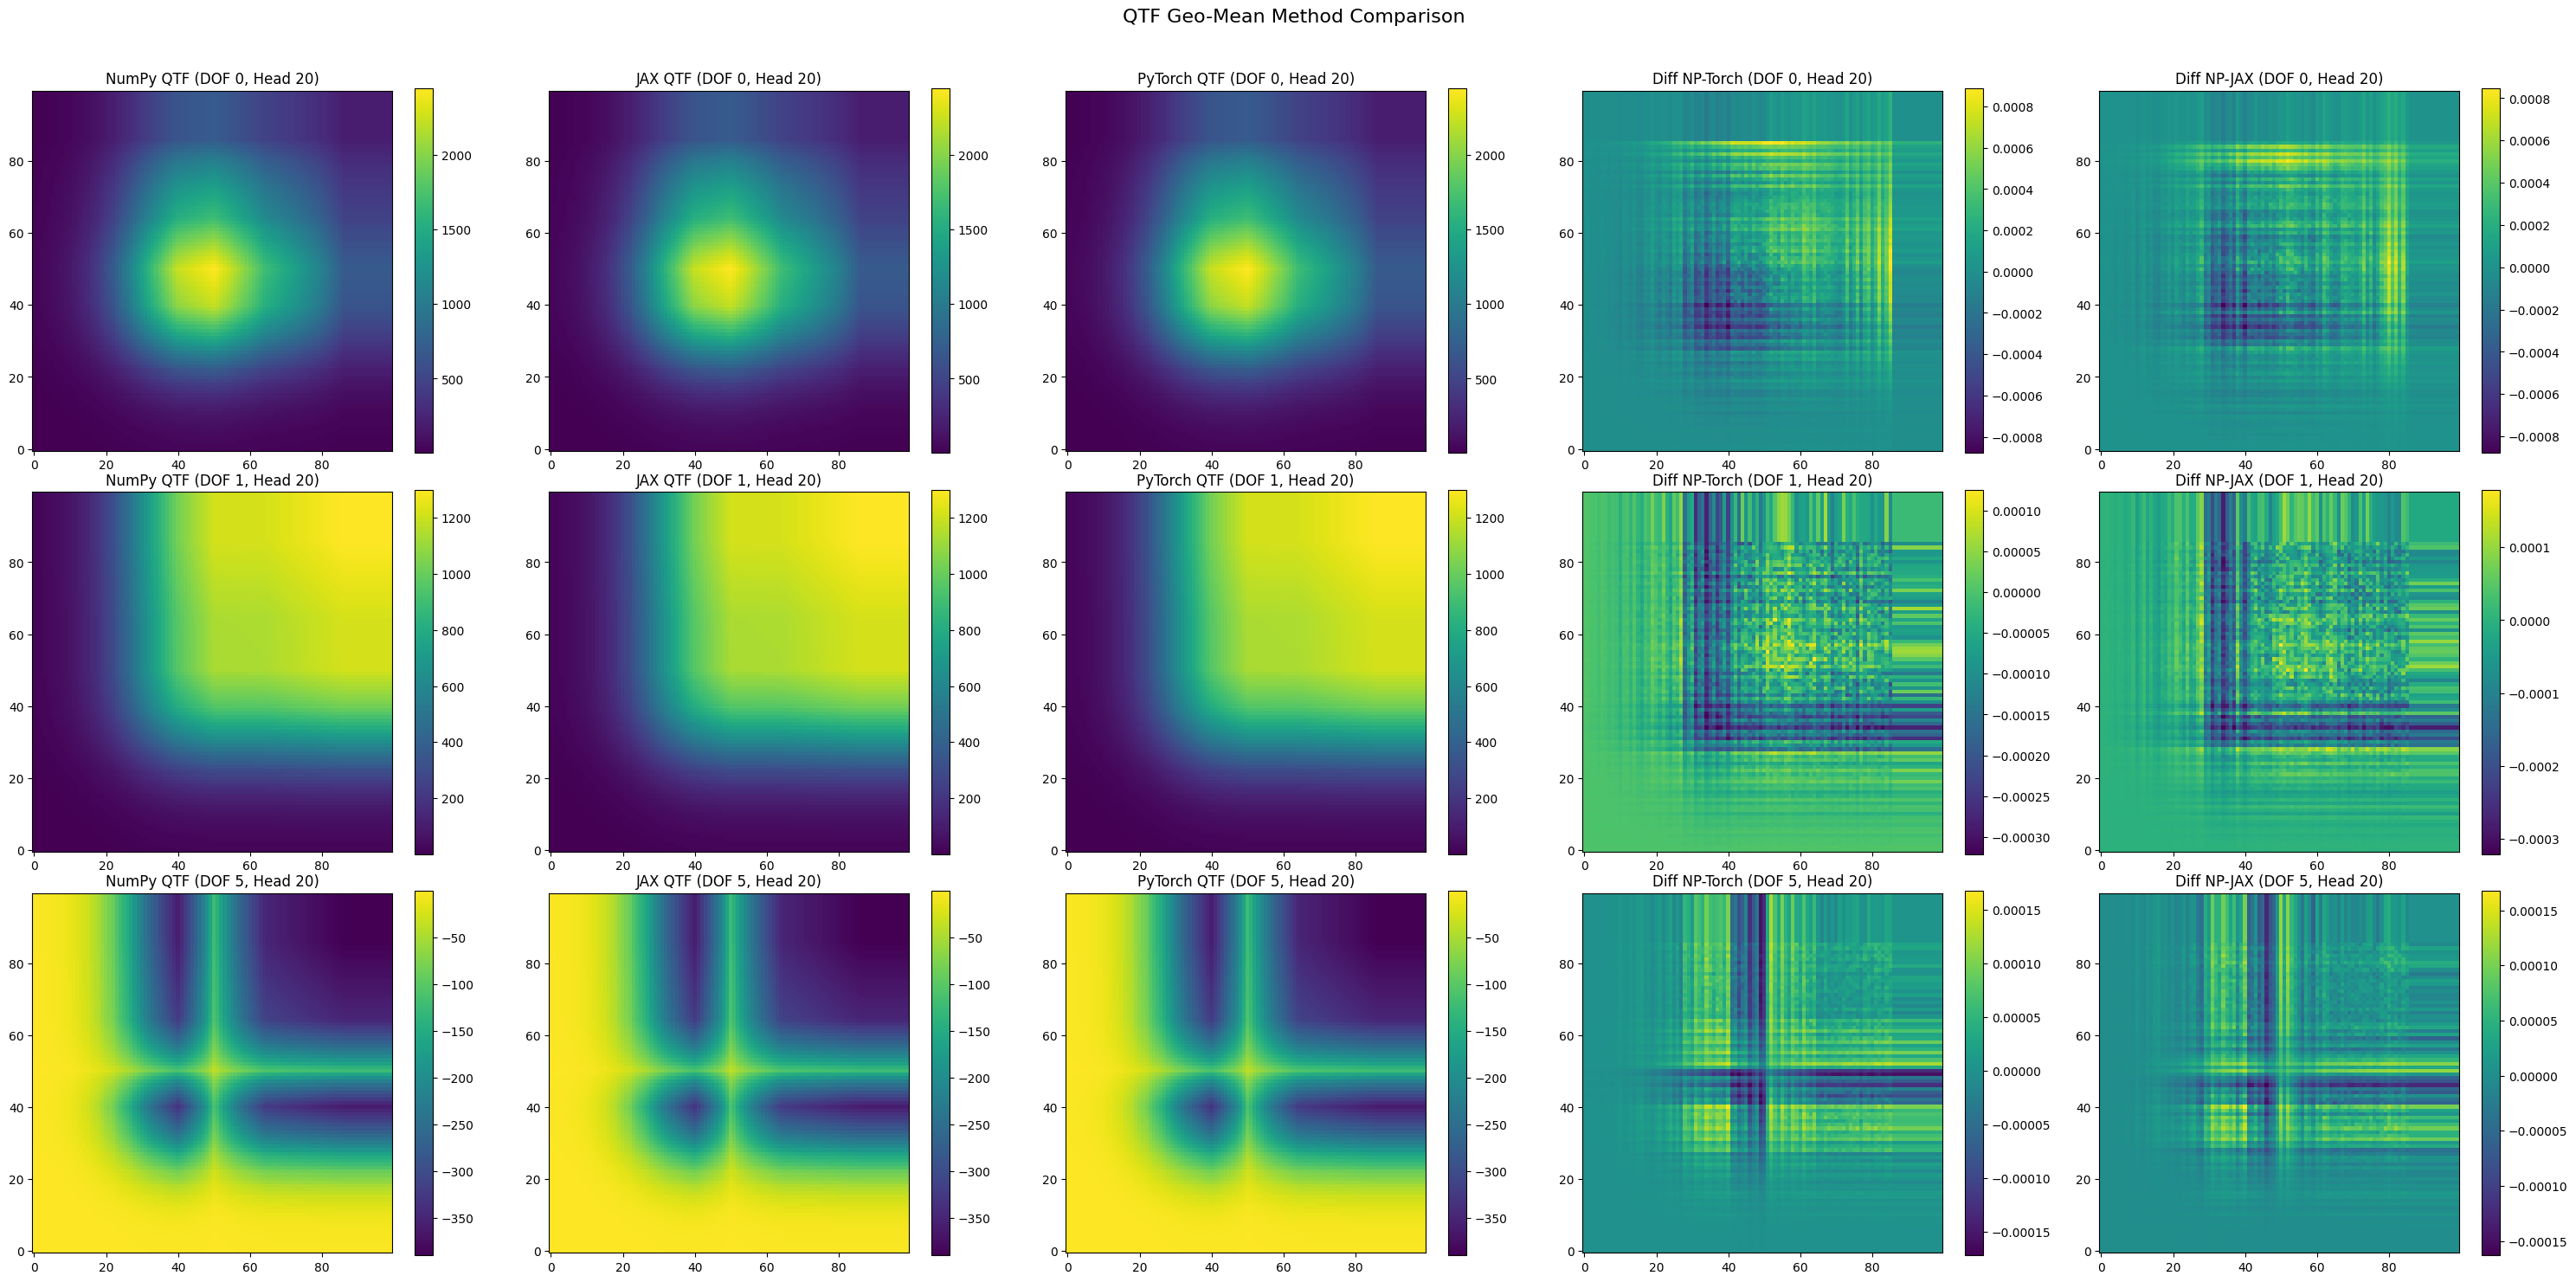

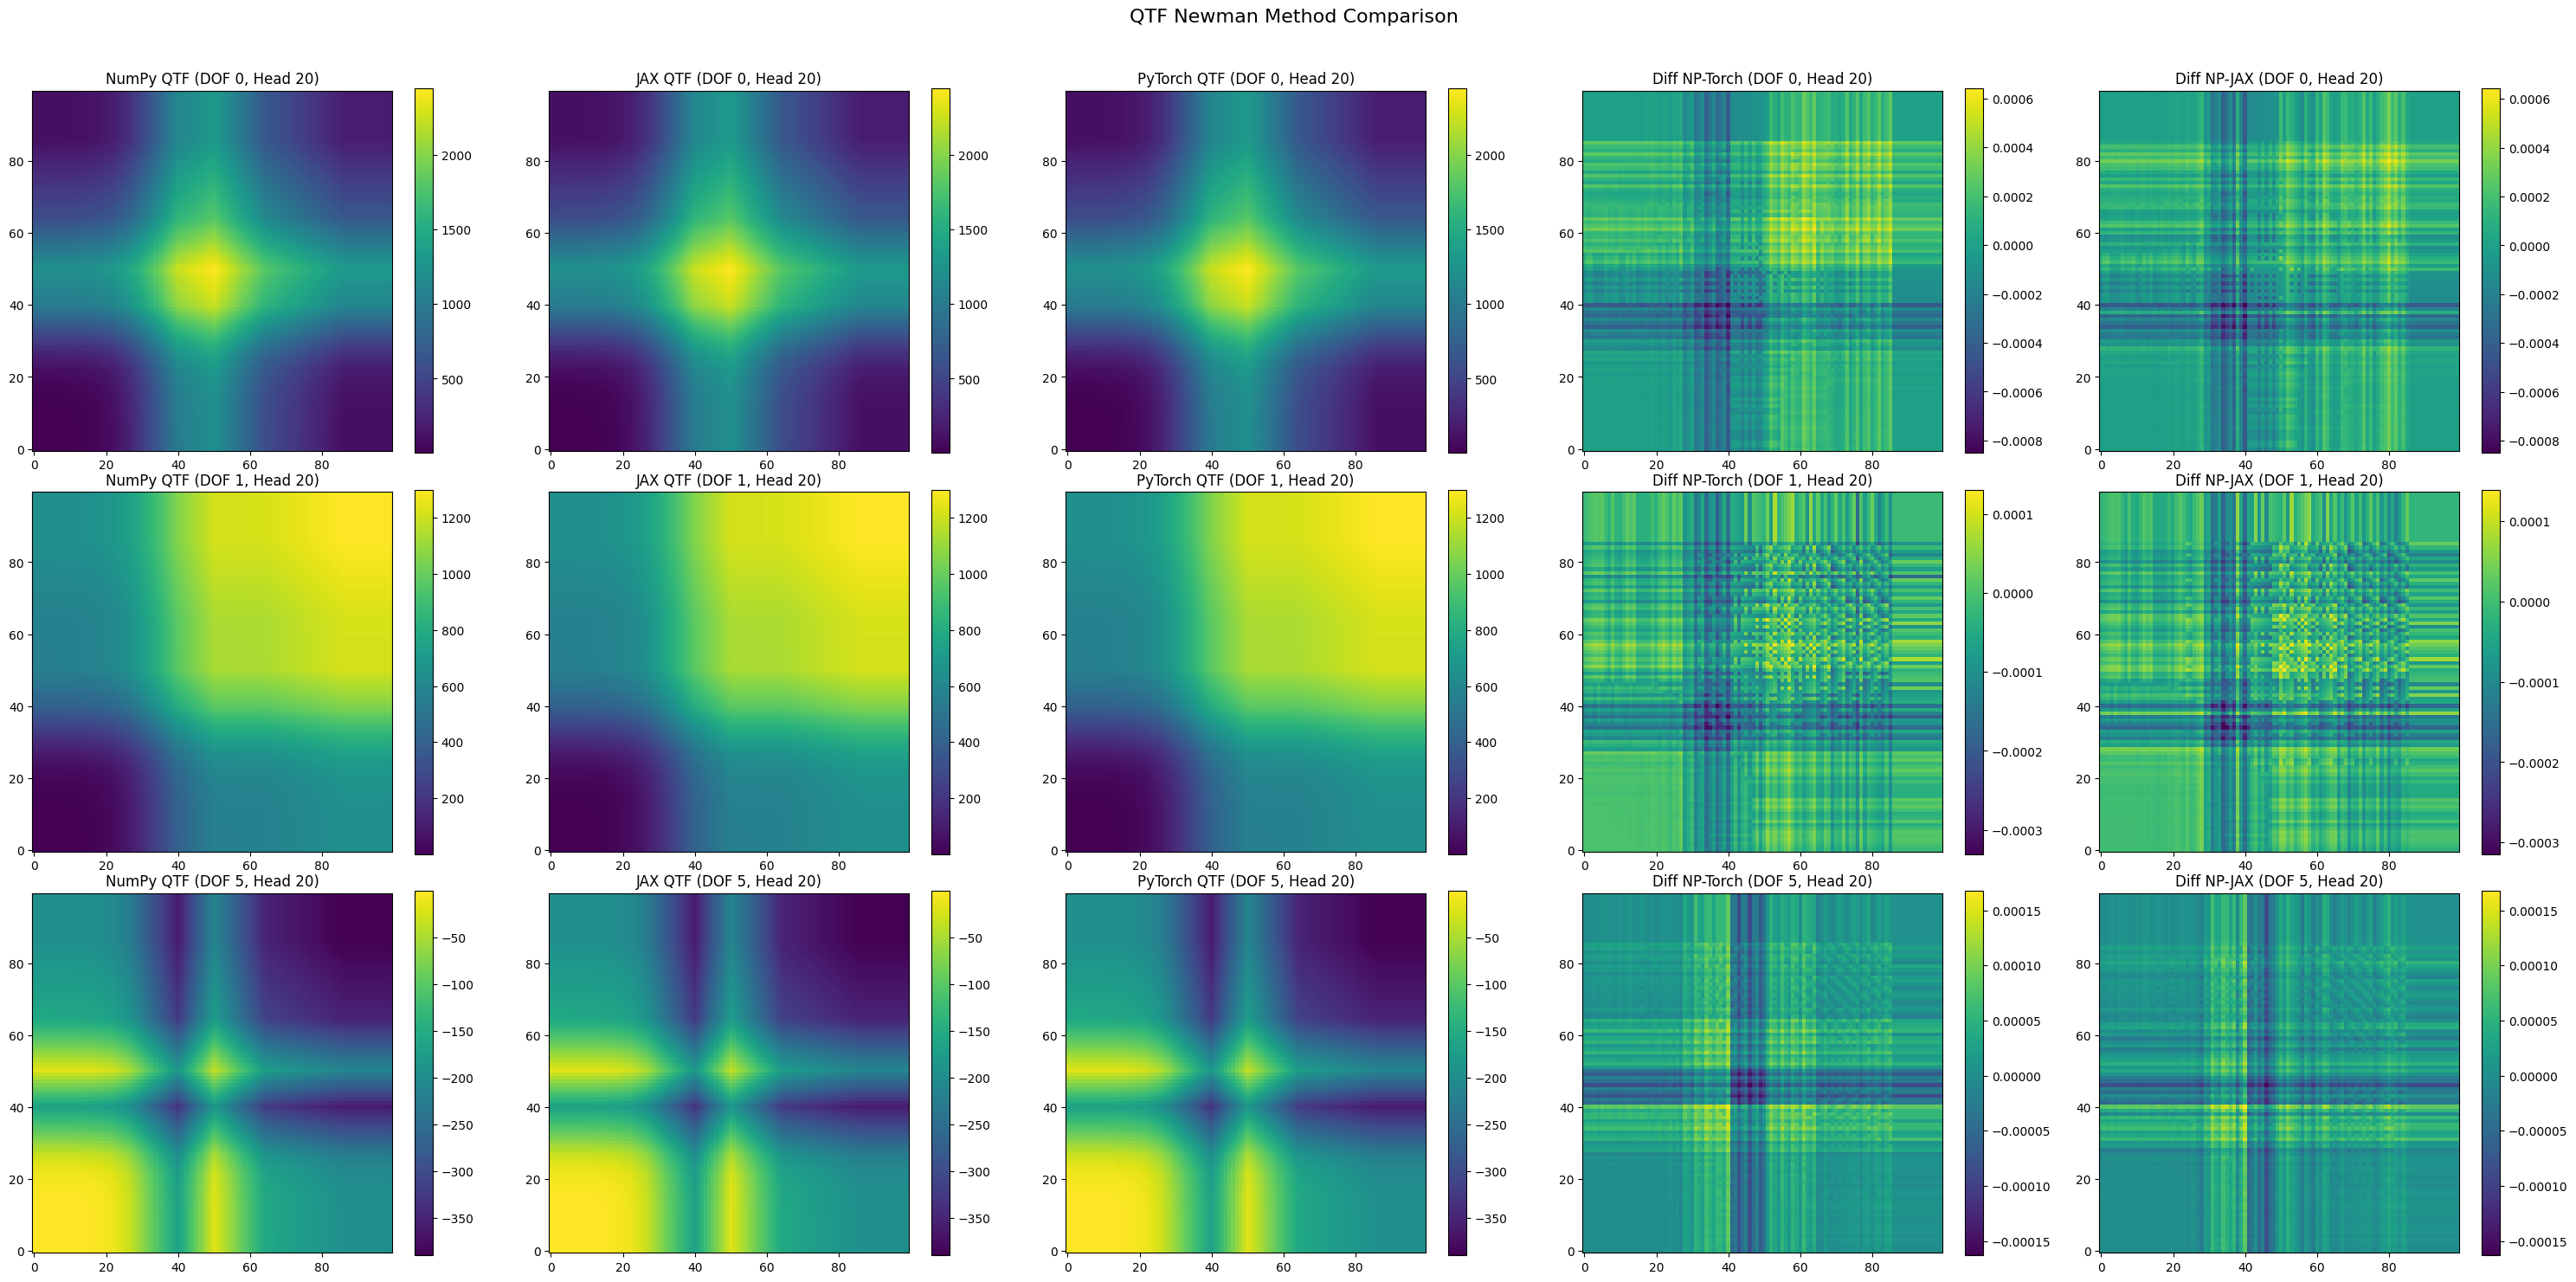

In [7]:
# ------------------------------
# Plot QTF matrices and their differences for selected DOFs (0, 1, 5).
# For illustration, we use the first heading index.
# ------------------------------

heading_index = 20  # Heading index to use for all plots
plot_dofs = [0, 1, 5]  # DOFs to include in the plots

# --- Geo-mean method ---
fig_geo, axes_geo = plt.subplots(len(plot_dofs), 5, figsize=(30, 15))  # 5 columns: NP, JAX, Torch, Diff(NP-Torch), Diff(NP-JAX)
fig_geo.suptitle("QTF Geo-Mean Method Comparison", fontsize=16)

for i, dof in enumerate(plot_dofs):
    # NumPy QTF slice
    im0 = axes_geo[i, 0].imshow(qtf_np_geo[dof, heading_index, :, :], origin="lower")
    axes_geo[i, 0].set_title(f"NumPy QTF (DOF {dof}, Head {heading_index})")
    fig_geo.colorbar(im0, ax=axes_geo[i, 0])

    # JAX QTF slice
    im1 = axes_geo[i, 1].imshow(qtf_jax_geo[dof, heading_index, :, :], origin="lower")
    axes_geo[i, 1].set_title(f"JAX QTF (DOF {dof}, Head {heading_index})")
    fig_geo.colorbar(im1, ax=axes_geo[i, 1])

    # PyTorch QTF slice
    im2 = axes_geo[i, 2].imshow(qtf_torch_geo[dof, heading_index, :, :], origin="lower")
    axes_geo[i, 2].set_title(f"PyTorch QTF (DOF {dof}, Head {heading_index})")
    fig_geo.colorbar(im2, ax=axes_geo[i, 2])

    # Difference (NumPy - PyTorch)
    im3 = axes_geo[i, 3].imshow(qtf_np_geo[dof, heading_index, :, :] - qtf_torch_geo[dof, heading_index, :, :], origin="lower")
    axes_geo[i, 3].set_title(f"Diff NP-Torch (DOF {dof}, Head {heading_index})")
    fig_geo.colorbar(im3, ax=axes_geo[i, 3])

    # Difference (NumPy - JAX)
    im4 = axes_geo[i, 4].imshow(qtf_np_geo[dof, heading_index, :, :] - qtf_jax_geo[dof, heading_index, :, :], origin="lower")
    axes_geo[i, 4].set_title(f"Diff NP-JAX (DOF {dof}, Head {heading_index})")
    fig_geo.colorbar(im4, ax=axes_geo[i, 4])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Newman method ---
fig_newman, axes_newman = plt.subplots(len(plot_dofs), 5, figsize=(30, 15)) # 5 columns: NP, JAX, Torch, Diff(NP-Torch), Diff(NP-JAX)
fig_newman.suptitle("QTF Newman Method Comparison", fontsize=16)

for i, dof in enumerate(plot_dofs):
    # NumPy QTF slice
    im0 = axes_newman[i, 0].imshow(qtf_np_newman[dof, heading_index, :, :], origin="lower")
    axes_newman[i, 0].set_title(f"NumPy QTF (DOF {dof}, Head {heading_index})")
    fig_newman.colorbar(im0, ax=axes_newman[i, 0])

    # JAX QTF slice
    im1 = axes_newman[i, 1].imshow(qtf_jax_newman[dof, heading_index, :, :], origin="lower")
    axes_newman[i, 1].set_title(f"JAX QTF (DOF {dof}, Head {heading_index})")
    fig_newman.colorbar(im1, ax=axes_newman[i, 1])

    # PyTorch QTF slice
    im2 = axes_newman[i, 2].imshow(qtf_torch_newman[dof, heading_index, :, :], origin="lower")
    axes_newman[i, 2].set_title(f"PyTorch QTF (DOF {dof}, Head {heading_index})")
    fig_newman.colorbar(im2, ax=axes_newman[i, 2])

    # Difference (NumPy - PyTorch)
    im3 = axes_newman[i, 3].imshow(qtf_np_newman[dof, heading_index, :, :] - qtf_torch_newman[dof, heading_index, :, :], origin="lower")
    axes_newman[i, 3].set_title(f"Diff NP-Torch (DOF {dof}, Head {heading_index})")
    fig_newman.colorbar(im3, ax=axes_newman[i, 3])

    # Difference (NumPy - JAX)
    im4 = axes_newman[i, 4].imshow(qtf_np_newman[dof, heading_index, :, :] - qtf_jax_newman[dof, heading_index, :, :], origin="lower")
    axes_newman[i, 4].set_title(f"Diff NP-JAX (DOF {dof}, Head {heading_index})")
    fig_newman.colorbar(im4, ax=axes_newman[i, 4])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:

# =============================================================================
# Extract and Compare Force RAO Arrays
# =============================================================================

# NumPy version
np_forceRAOamp = numpy_wl_geo._forceRAOamp       # Shape: (6, N, number of headings)
np_forceRAOphase = numpy_wl_geo._forceRAOphase

# JAX version
jax_forceRAOamp = np.array(jax_wl_geo.forceRAOamp)     # Convert JAX array to NumPy
jax_forceRAOphase = np.array(jax_wl_geo.forceRAOphase)

# PyTorch version
torch_forceRAOamp = torch_wl_geo._forceRAOamp.detach().cpu().numpy() # Convert to NumPy
torch_forceRAOphase = torch_wl_geo._forceRAOphase.detach().cpu().numpy()

# Print shapes for amplitude and phase arrays.
print("--- Force RAO Amplitudes Shapes ---")
print("  NumPy:", np_forceRAOamp.shape)
print("  JAX:", jax_forceRAOamp.shape)
print("  PyTorch:", torch_forceRAOamp.shape)

print("\n--- Force RAO Phase Shapes ---")
print("  NumPy:", np_forceRAOphase.shape)
print("  JAX:", jax_forceRAOphase.shape)
print("  PyTorch:", torch_forceRAOphase.shape)

--- Force RAO Amplitudes Shapes ---
  NumPy: (6, 100, 36)
  JAX: (6, 100, 36)
  PyTorch: (6, 100, 36)

--- Force RAO Phase Shapes ---
  NumPy: (6, 100, 36)
  JAX: (6, 100, 36)
  PyTorch: (6, 100, 36)


In [9]:
# Compute difference statistics
diff_amp_jax = np.abs(np_forceRAOamp - jax_forceRAOamp)
diff_phase_jax = np.abs(np_forceRAOphase - jax_forceRAOphase)
print("--- Force RAO Amplitude Differences ---")
print("Max diff (NumPy vs JAX):", np.max(diff_amp_jax), "Mean diff:", np.mean(diff_amp_jax))

diff_amp_torch = np.abs(np_forceRAOamp - torch_forceRAOamp)
diff_phase_torch = np.abs(np_forceRAOphase - torch_forceRAOphase)
print("Max diff (NumPy vs PyTorch):", np.max(diff_amp_torch), "Mean diff:", np.mean(diff_amp_torch))

print("\n--- Force RAO Phase Differences ---")
print("Max diff (NumPy vs JAX):", np.max(diff_phase_jax), "Mean diff:", np.mean(diff_phase_jax))
print("Max diff (NumPy vs PyTorch):", np.max(diff_phase_torch), "Mean diff:", np.mean(diff_phase_torch))

--- Force RAO Amplitude Differences ---
Max diff (NumPy vs JAX): 0.0015922405762012204 Mean diff: 8.891197292666256e-05
Max diff (NumPy vs PyTorch): 0.0015518424243055051 Mean diff: 0.00010308670484404382

--- Force RAO Phase Differences ---
Max diff (NumPy vs JAX): 1.2755959949428686e-07 Mean diff: 7.975523469823272e-09
Max diff (NumPy vs PyTorch): 1.242111066085405e-07 Mean diff: 7.41186500561523e-09


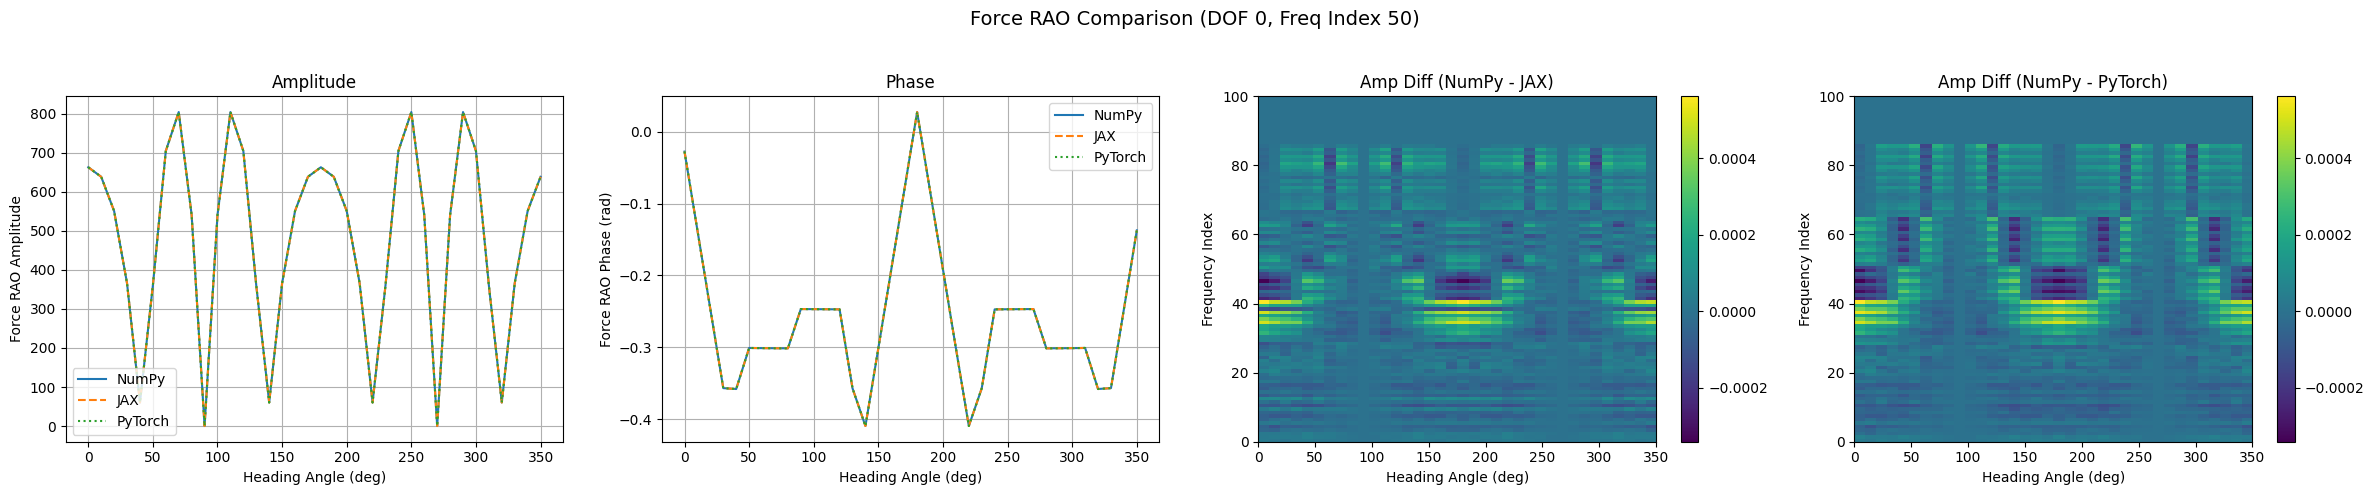

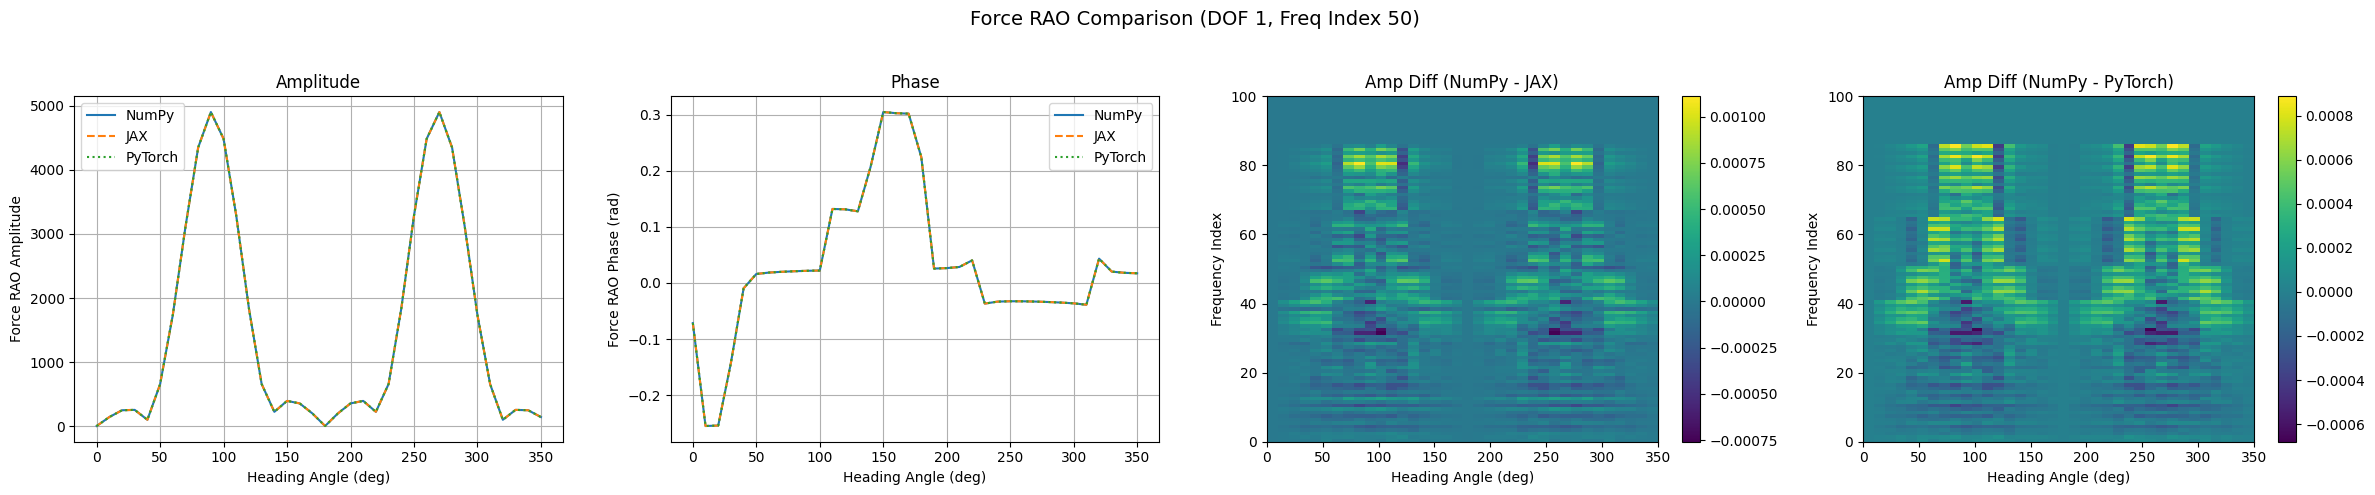

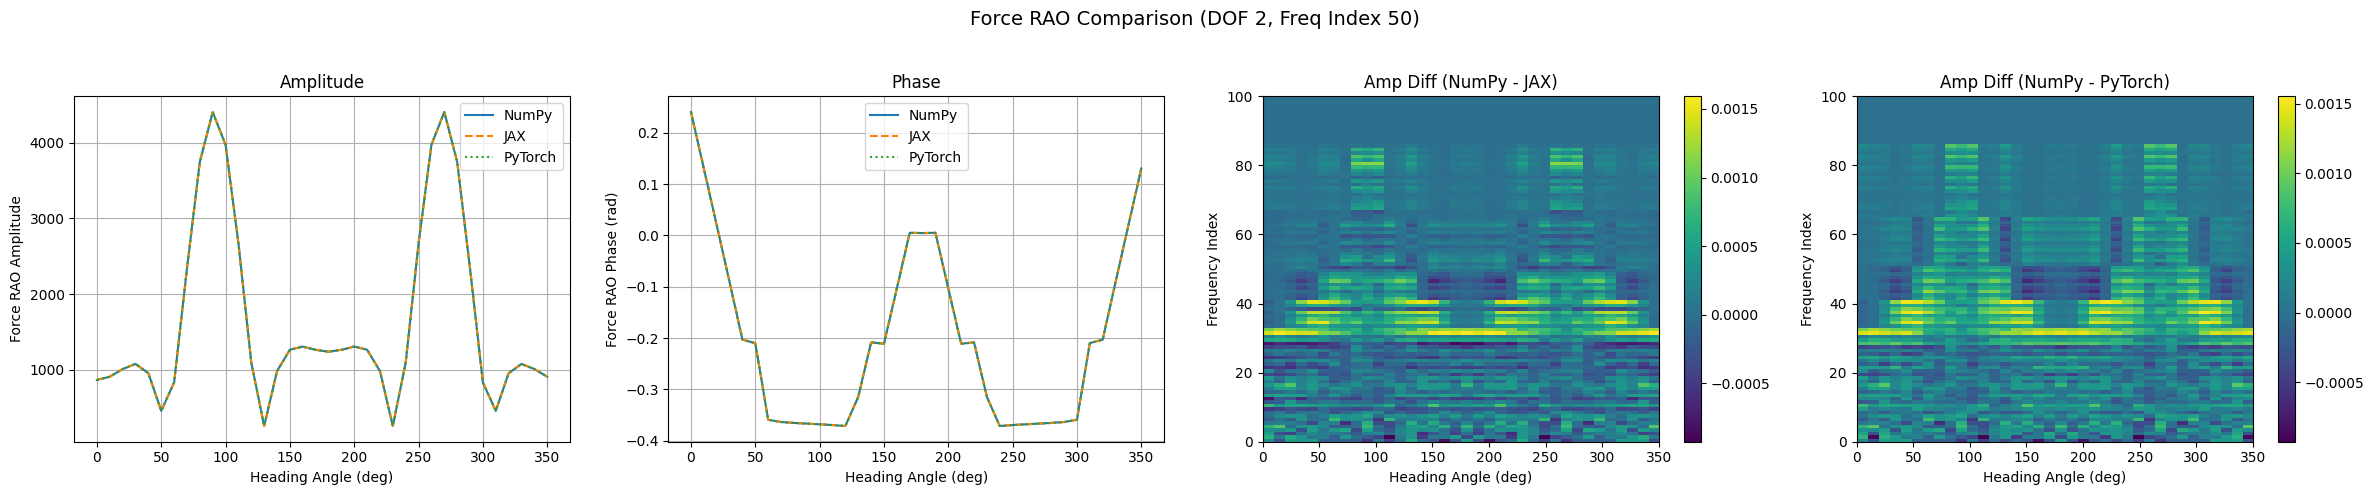

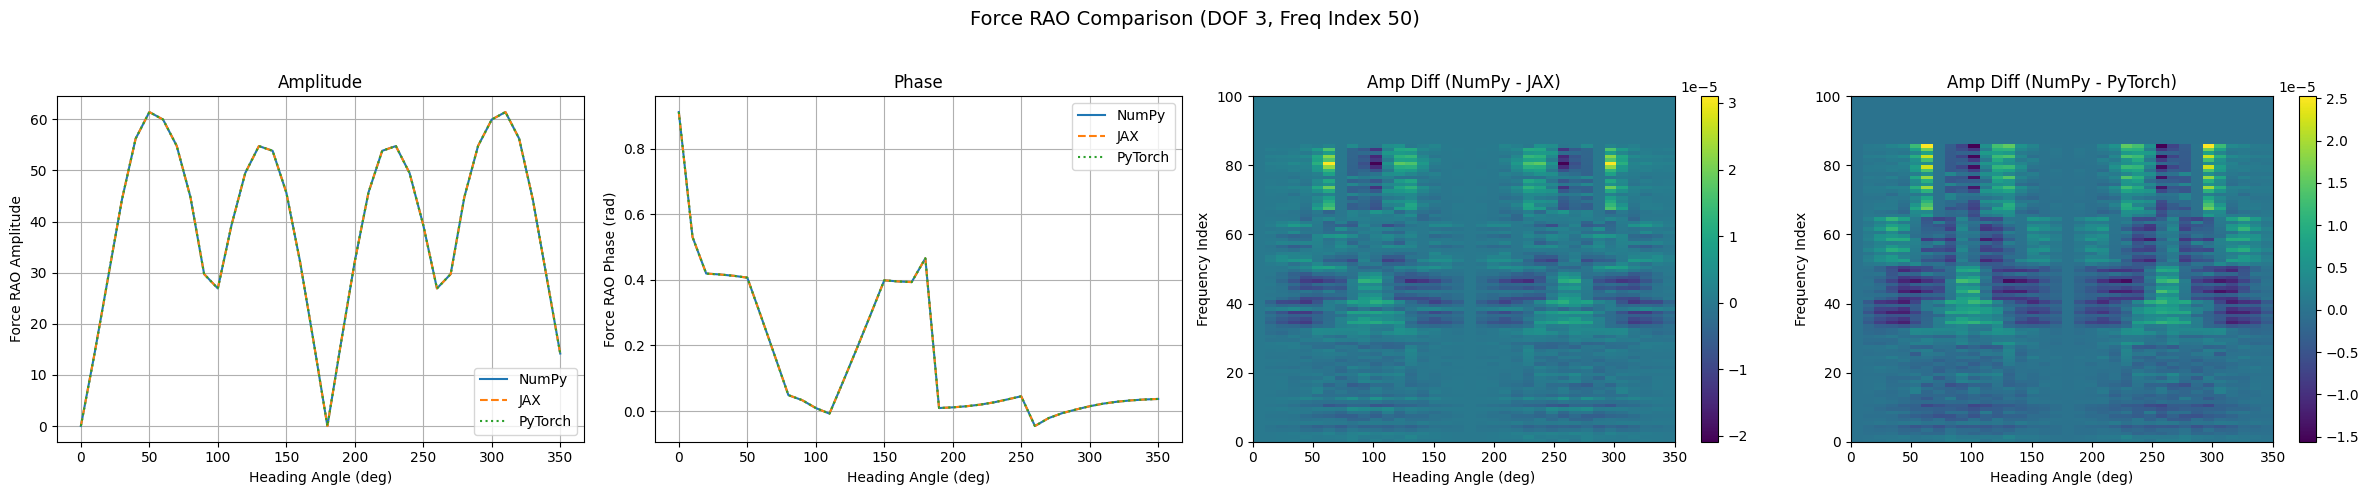

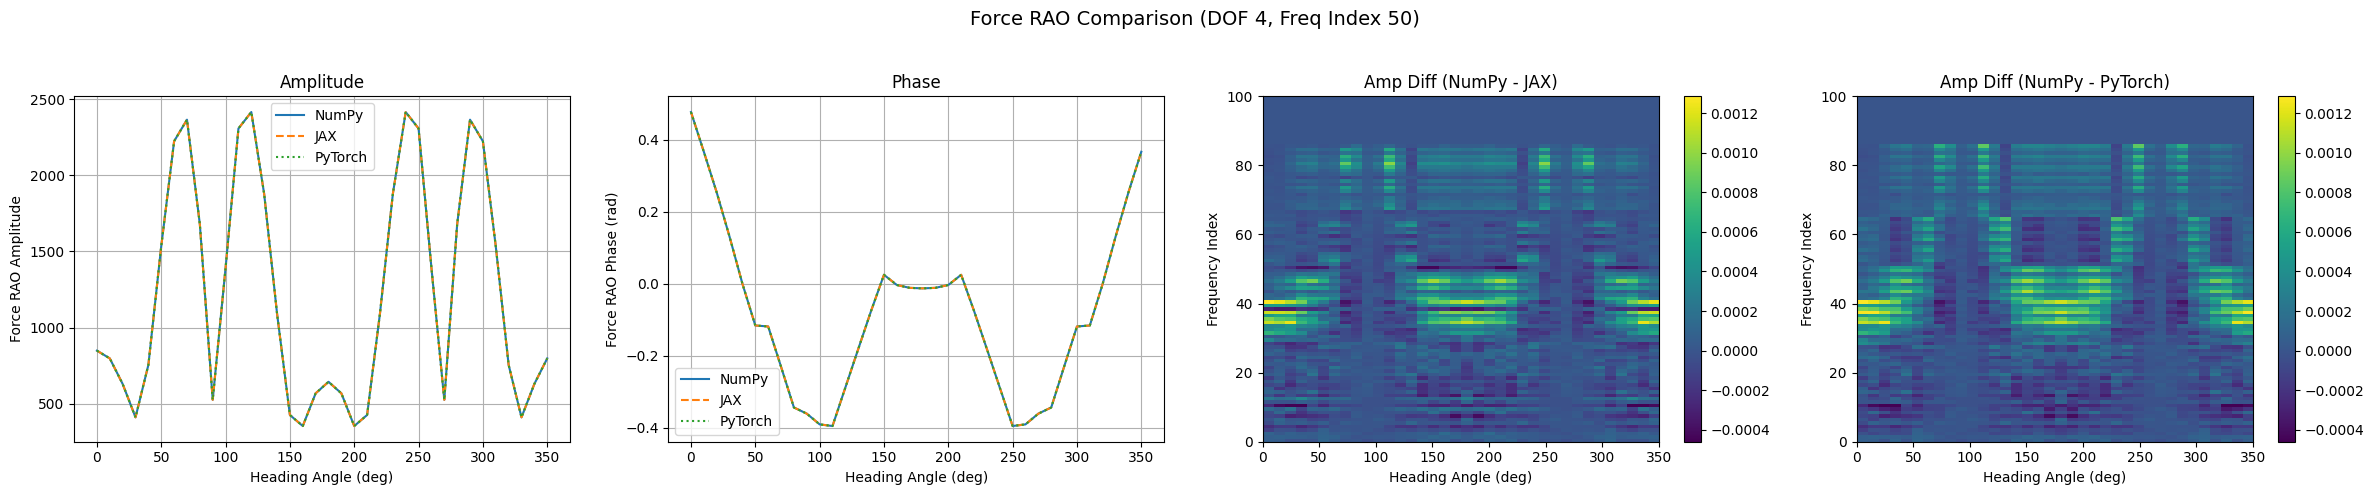

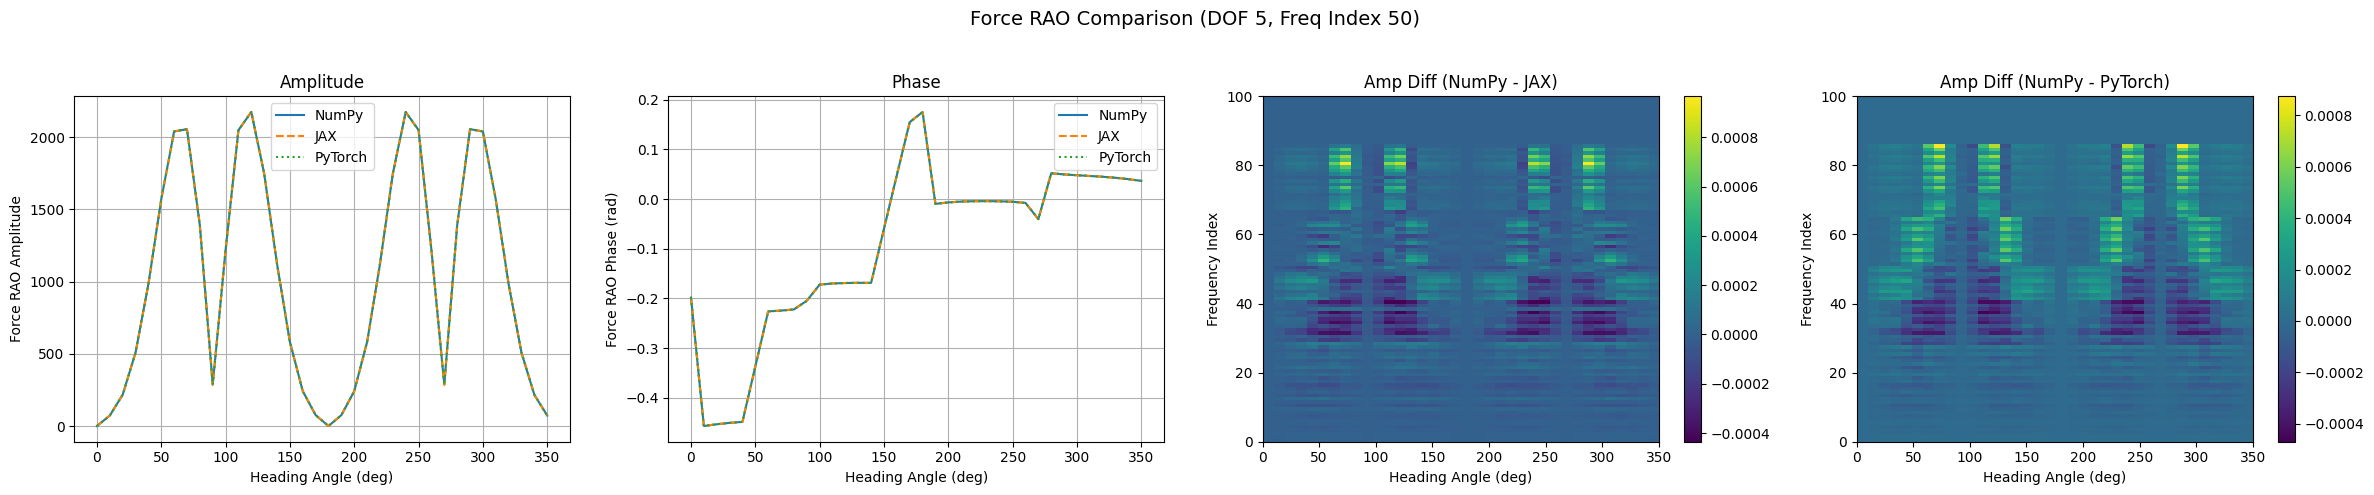

In [10]:
# Get heading angles in degrees from the NumPy instance 
heading_angles = np.rad2deg(numpy_wl_geo._qtf_angles)  # e.g., 360 heading values

# Plot representative slices for all 6 DOFs
freq_index = 50 # Example frequency index for a slice across heading angles (adjust if needed)

for dof in range(6):  # Loop over all 6 DOFs
    fig_rao, ax_rao = plt.subplots(1, 4, figsize=(24, 5)) # 4 plots: Amp, Phase, Diff(NP-JAX), Diff(NP-Torch)
    fig_rao.suptitle(f"Force RAO Comparison (DOF {dof}, Freq Index {freq_index})", fontsize=14)

    # Force RAO Amplitude plot
    ax_rao[0].plot(heading_angles, np_forceRAOamp[dof, freq_index, :], label="NumPy")
    ax_rao[0].plot(heading_angles, jax_forceRAOamp[dof, freq_index, :], label="JAX", linestyle="--")
    ax_rao[0].plot(heading_angles, torch_forceRAOamp[dof, freq_index, :], label="PyTorch", linestyle=":")
    ax_rao[0].set_title(f"Amplitude")
    ax_rao[0].set_xlabel("Heading Angle (deg)")
    ax_rao[0].set_ylabel("Force RAO Amplitude")
    ax_rao[0].legend()
    ax_rao[0].grid(True)

    # Force RAO Phase plot
    ax_rao[1].plot(heading_angles, np_forceRAOphase[dof, freq_index, :], label="NumPy")
    ax_rao[1].plot(heading_angles, jax_forceRAOphase[dof, freq_index, :], label="JAX", linestyle="--")
    ax_rao[1].plot(heading_angles, torch_forceRAOphase[dof, freq_index, :], label="PyTorch", linestyle=":")
    ax_rao[1].set_title(f"Phase")
    ax_rao[1].set_xlabel("Heading Angle (deg)")
    ax_rao[1].set_ylabel("Force RAO Phase (rad)")
    ax_rao[1].legend()
    ax_rao[1].grid(True)

    # Difference in Force RAO Amplitude (NumPy - JAX) - Full Matrix
    extent = [heading_angles[0], heading_angles[-1], 0, np_forceRAOamp[dof].shape[0]]
    im_diff_jax = ax_rao[2].imshow(np_forceRAOamp[dof] - jax_forceRAOamp[dof], aspect="auto",
                            origin="lower", extent=extent)
    ax_rao[2].set_title(f"Amp Diff (NumPy - JAX)")
    ax_rao[2].set_xlabel("Heading Angle (deg)")
    ax_rao[2].set_ylabel("Frequency Index")
    plt.colorbar(im_diff_jax, ax=ax_rao[2])

    # Difference in Force RAO Amplitude (NumPy - PyTorch) - Full Matrix
    im_diff_torch = ax_rao[3].imshow(np_forceRAOamp[dof] - torch_forceRAOamp[dof], aspect="auto",
                            origin="lower", extent=extent)
    ax_rao[3].set_title(f"Amp Diff (NumPy - PyTorch)")
    ax_rao[3].set_xlabel("Heading Angle (deg)")
    ax_rao[3].set_ylabel("Frequency Index")
    plt.colorbar(im_diff_torch, ax=ax_rao[3])

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout
    plt.show()


=== Comparing RAO Interpolation Outputs ===
RAO Interpolation Output Shapes:
  NumPy   rao_amp: (6, 100) rao_phase: (6, 100)
  JAX     rao_amp: (6, 100) rao_phase: (6, 100)
  PyTorch rao_amp: (6, 100) rao_phase: (6, 100)

RAO Amplitude Interpolation Differences:
  Max diff (NumPy vs JAX): 0.0017764397698556422   Mean diff: 0.0002313938081929745
  Max diff (NumPy vs PyTorch): 0.0014098223691689782   Mean diff: 0.000212187111686483

RAO Phase Interpolation Differences:
  Max diff (NumPy vs JAX): 2.1500953317765692e-07   Mean diff: 7.107715311747744e-08
  Max diff (NumPy vs PyTorch): 2.162957667972698e-07   Mean diff: 7.017861481477955e-08


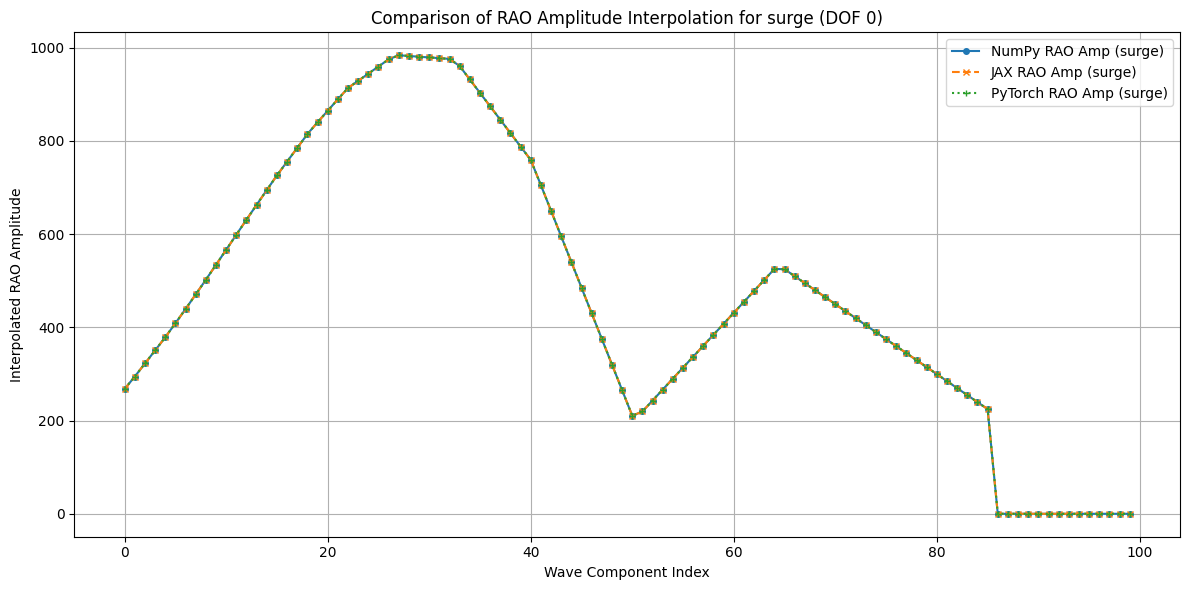

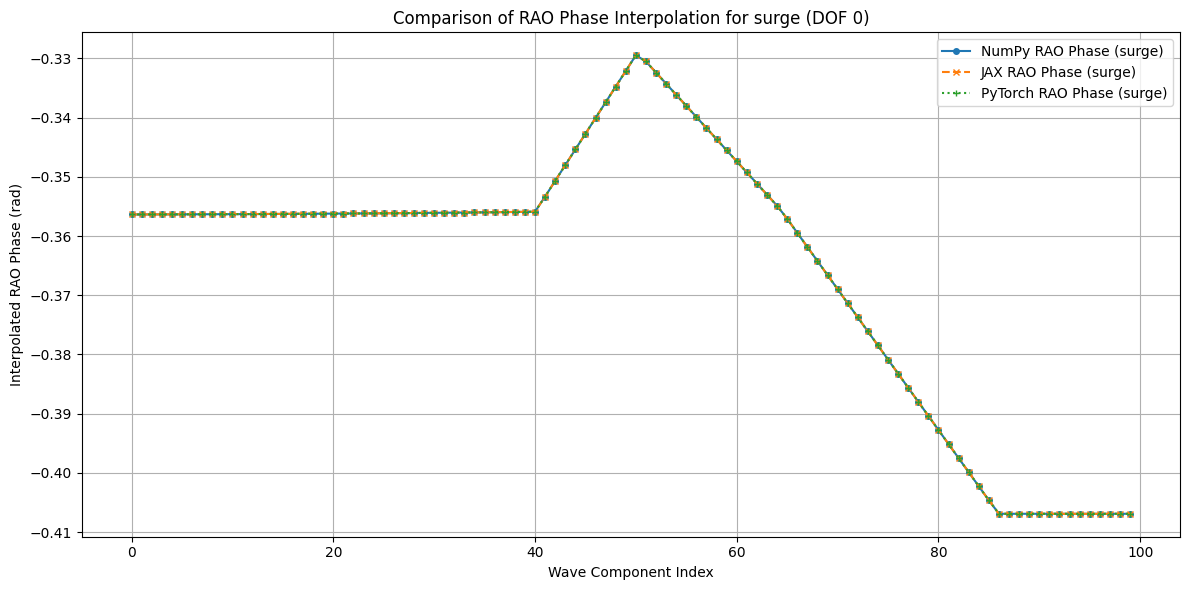

In [11]:
# =============================================================================",
# Compare RAO Interpolation Outputs
# =============================================================================",

print("\n=== Comparing RAO Interpolation Outputs ===")

# For all implementations, we need a relative incident angle array.
# Use a representative heading, for example, heading = 0 (radians).
heading_for_test = 0
heading_for_test_torch = torch.tensor(heading_for_test, dtype=torch.float32) # PyTorch needs a tensor

# ----------------------------
# NumPy version: use the internal _relative_incident_angle and _rao_interp.
# ----------------------------
rel_angle_np = numpy_wl_geo._relative_incident_angle(heading_for_test)
# This returns a vector of relative incident angles (one per wave component)
rao_amp_np_interp, rao_phase_np_interp = numpy_wl_geo._rao_interp(rel_angle_np)

# ----------------------------
# JAX version: use the functional equivalents.
# ----------------------------
# Compute the relative incident angle for the JAX implementation.
rel_angle_jax = jax_relative_incident_angle(jax_wl_geo.angles, heading_for_test)
# Compute the RAO interpolation using the JAX function.
rao_amp_jax_interp, rao_phase_jax_interp = jax_rao_interp(jax_wl_geo.forceRAOamp,
                                                          jax_wl_geo.forceRAOphase,
                                                          jax_wl_geo.qtf_angles,
                                                          rel_angle_jax)
# Convert the JAX outputs to NumPy arrays for comparison.
rao_amp_jax_interp_np = np.array(rao_amp_jax_interp)
rao_phase_jax_interp_np = np.array(rao_phase_jax_interp)

# ----------------------------
# PyTorch version: use the internal methods.
# ----------------------------
# Compute the relative incident angle for the PyTorch implementation.
rel_angle_torch = torch_wl_geo._relative_incident_angle(heading_for_test_torch)
# Compute the RAO interpolation using the PyTorch method.
rao_amp_torch_interp, rao_phase_torch_interp = torch_wl_geo._rao_interp(rel_angle_torch)
# Convert the PyTorch outputs to NumPy arrays for comparison.
rao_amp_torch_interp_np = rao_amp_torch_interp.detach().cpu().numpy()
rao_phase_torch_interp_np = rao_phase_torch_interp.detach().cpu().numpy()


# ----------------------------
# Compare the shapes.
# ----------------------------
print("RAO Interpolation Output Shapes:")
print("  NumPy   rao_amp:", rao_amp_np_interp.shape, "rao_phase:", rao_phase_np_interp.shape)
print("  JAX     rao_amp:", rao_amp_jax_interp_np.shape, "rao_phase:", rao_phase_jax_interp_np.shape)
print("  PyTorch rao_amp:", rao_amp_torch_interp_np.shape, "rao_phase:", rao_phase_torch_interp_np.shape)


# ----------------------------
# Compute and print difference statistics.
# ----------------------------
rao_amp_diff_jax = np.abs(rao_amp_np_interp - rao_amp_jax_interp_np)
rao_phase_diff_jax = np.abs(rao_phase_np_interp - rao_phase_jax_interp_np)
rao_amp_diff_torch = np.abs(rao_amp_np_interp - rao_amp_torch_interp_np)
rao_phase_diff_torch = np.abs(rao_phase_np_interp - rao_phase_torch_interp_np)

print("\nRAO Amplitude Interpolation Differences:")
print("  Max diff (NumPy vs JAX):", np.max(rao_amp_diff_jax),
      "  Mean diff:", np.mean(rao_amp_diff_jax))
print("  Max diff (NumPy vs PyTorch):", np.max(rao_amp_diff_torch),
      "  Mean diff:", np.mean(rao_amp_diff_torch))

print("\nRAO Phase Interpolation Differences:")
print("  Max diff (NumPy vs JAX):", np.max(rao_phase_diff_jax),
      "  Mean diff:", np.mean(rao_phase_diff_jax))
print("  Max diff (NumPy vs PyTorch):", np.max(rao_phase_diff_torch),
      "  Mean diff:", np.mean(rao_phase_diff_torch))


# ----------------------------
# Plot a representative comparison for one DOF.
# ----------------------------
# Here, we plot the RAO amplitude as a function of the QTF angles (in degrees)
qtf_angles_deg = np.rad2deg(numpy_wl_geo._qtf_angles)

# Interpolate qtf_angles_deg to match the shape of the RAO amplitude arrays (N points)
# The interpolated RAO arrays have shape (6, N), where N is the number of wave components.
# We need an x-axis that corresponds to these N points.
# The relative angle calculation produces N angles, one for each wave component.
# We can plot against the relative angles calculated by NumPy (or JAX/Torch, they should be similar).
# Or, more simply, plot against the index of the wave component.
wave_component_indices = np.arange(rao_amp_np_interp.shape[1]) # Should be 0 to N-1

plt.figure(figsize=(12, 6))
plt.plot(wave_component_indices, rao_amp_np_interp[0, :], label="NumPy RAO Amp (surge)", marker="o", markersize=4)
plt.plot(wave_component_indices, rao_amp_jax_interp_np[0, :], label="JAX RAO Amp (surge)", marker="x", linestyle="--", markersize=4)
plt.plot(wave_component_indices, rao_amp_torch_interp_np[0, :], label="PyTorch RAO Amp (surge)", marker="+", linestyle=":", markersize=4)
plt.xlabel("Wave Component Index")
plt.ylabel("Interpolated RAO Amplitude")
plt.title("Comparison of RAO Amplitude Interpolation for surge (DOF 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Plot the phase comparison
# ----------------------------
plt.figure(figsize=(12, 6))
plt.plot(wave_component_indices, rao_phase_np_interp[0, :], label="NumPy RAO Phase (surge)", marker="o", markersize=4)
plt.plot(wave_component_indices, rao_phase_jax_interp_np[0, :], label="JAX RAO Phase (surge)", marker="x", linestyle="--", markersize=4)
plt.plot(wave_component_indices, rao_phase_torch_interp_np[0, :], label="PyTorch RAO Phase (surge)", marker="+", linestyle=":", markersize=4)
plt.xlabel("Wave Component Index")
plt.ylabel("Interpolated RAO Phase (rad)")
plt.title("Comparison of RAO Phase Interpolation for surge (DOF 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# =============================================================================
# Compare First-Order Wave Loads over a range of time
# =============================================================================

# Create an array of time values
time_vals = np.linspace(0, 10, num=100)
eta_test_np = np.zeros(6)
eta_test_jax = jnp.zeros(6)
eta_test_torch = torch.zeros(6)

# NumPy
np_first_order_loads = np.array([numpy_wl_geo.first_order_loads(t, eta_test_np) for t in time_vals])

# JAX
jax_first_order_loads_all = np.array([np.array(jax_first_order_loads(t, eta_test_jax, jax_wl_geo))
                                      for t in time_vals])

# PyTorch
torch_first_order_loads_all_t = [torch_wl_geo.first_order_loads(torch.tensor(t, dtype=torch.float32), eta_test_torch) for t in time_vals]
torch_first_order_loads_all = np.array([load.detach().cpu().numpy() for load in torch_first_order_loads_all_t])

print("\n--- First Order Wave Loads Comparison over time ---")
print("NumPy Loads shape:", np_first_order_loads.shape)
print("JAX Loads shape:", jax_first_order_loads_all.shape)
print("PyTorch Loads shape:", torch_first_order_loads_all.shape)

# Difference Stats
diff_fo_jax = np.abs(np_first_order_loads - jax_first_order_loads_all)
diff_fo_torch = np.abs(np_first_order_loads - torch_first_order_loads_all)
print("Max diff (NP vs JAX):", np.max(diff_fo_jax), "Mean diff:", np.mean(diff_fo_jax))
print("Max diff (NP vs Torch):", np.max(diff_fo_torch), "Mean diff:", np.mean(diff_fo_torch))


--- First Order Wave Loads Comparison over time ---
NumPy Loads shape: (100, 6)
JAX Loads shape: (100, 6)
PyTorch Loads shape: (100, 6)
Max diff (NP vs JAX): 0.028655976552727225 Mean diff: 0.003517648630259923
Max diff (NP vs Torch): 0.03388777764075712 Mean diff: 0.0031689350562234416


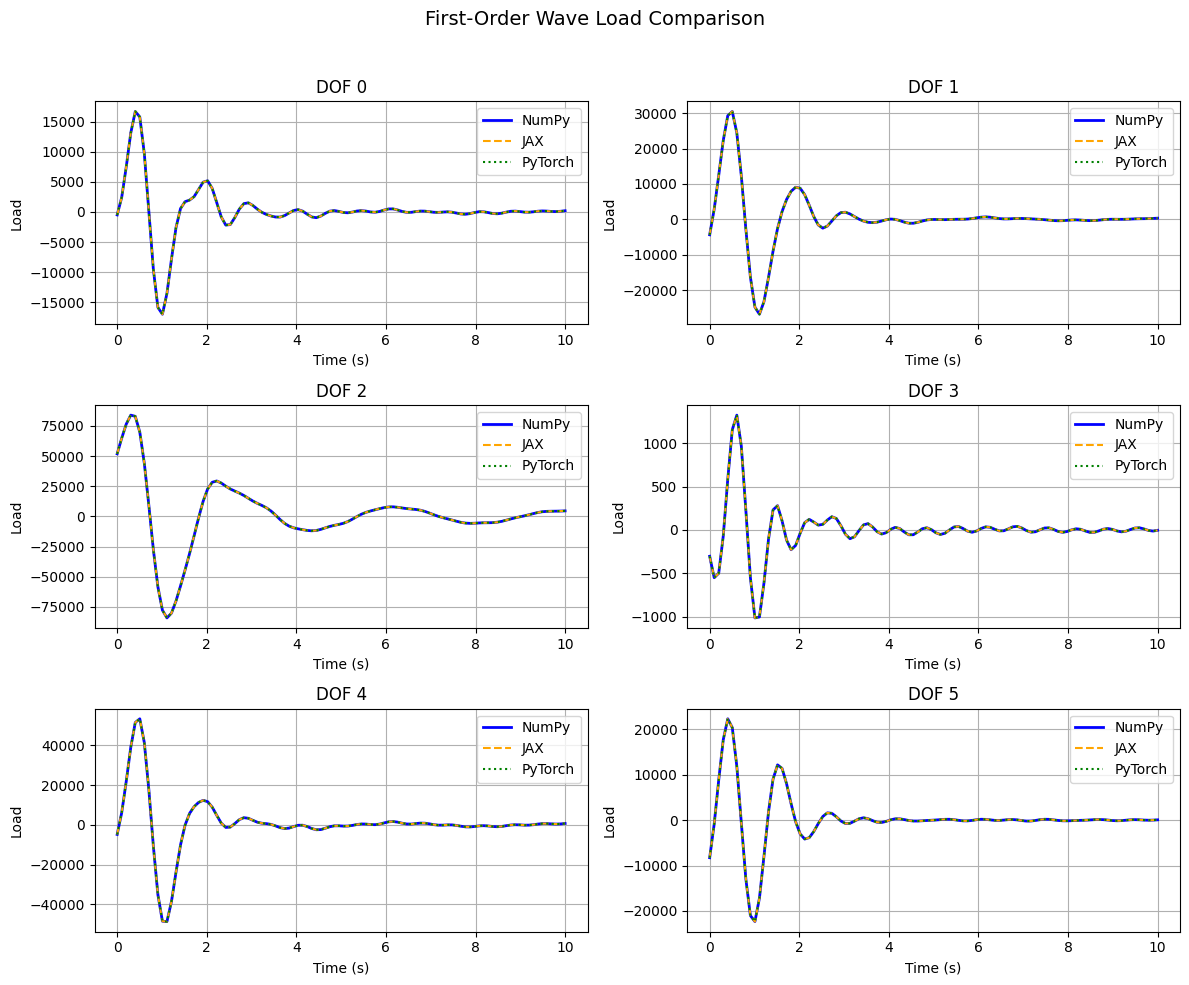

In [13]:
# plot the first order loads
fig_fo, axes_fo = plt.subplots(3, 2, figsize=(12, 10))
fig_fo.suptitle("First-Order Wave Load Comparison", fontsize=14)
for i in range(3):
    for j in range(2):
        dof_idx = i * 2 + j
        ax = axes_fo[i, j]
        ax.plot(time_vals, np_first_order_loads[:, dof_idx], label="NumPy", color='blue', linewidth=2)
        ax.plot(time_vals, jax_first_order_loads_all[:, dof_idx], label="JAX", linestyle='--', color='orange', linewidth=1.5)
        ax.plot(time_vals, torch_first_order_loads_all[:, dof_idx], label="PyTorch", linestyle=':', color='green', linewidth=1.5)
        ax.set_title(f"DOF {dof_idx}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Load")
        ax.legend()
        ax.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
# =============================================================================
# Compare Second-Order Wave Loads over a range of time
# =============================================================================

# Use the same time_vals and eta_test
heading_test_np = eta_test_np[-1]
heading_test_jax = eta_test_jax[-1]
heading_test_torch = eta_test_torch[-1]

# NumPy
np_second_order_loads = np.array([numpy_wl_geo.second_order_loads(t, heading_test_np) for t in time_vals])

# JAX
jax_second_order_loads_all = np.array([np.array(jax_second_order_loads(t, heading_test_jax, jax_wl_geo))
                                       for t in time_vals])

# PyTorch
torch_second_order_loads_all_t = [torch_wl_geo.second_order_loads(torch.tensor(t, dtype=torch.float32), heading_test_torch) for t in time_vals]
torch_second_order_loads_all = np.array([load.detach().cpu().numpy() for load in torch_second_order_loads_all_t])

print("\n--- Second Order Wave Loads Comparison over time ---")
print("NumPy Loads shape:", np_second_order_loads.shape)
print("JAX Loads shape:", jax_second_order_loads_all.shape)
print("PyTorch Loads shape:", torch_second_order_loads_all.shape)

# Difference Stats
diff_so_jax = np.abs(np_second_order_loads - jax_second_order_loads_all)
diff_so_torch = np.abs(np_second_order_loads - torch_second_order_loads_all)
print("Max diff (NP vs JAX):", np.max(diff_so_jax), "Mean diff:", np.mean(diff_so_jax))
print("Max diff (NP vs Torch):", np.max(diff_so_torch), "Mean diff:", np.mean(diff_so_torch))


--- Second Order Wave Loads Comparison over time ---
NumPy Loads shape: (100, 6)
JAX Loads shape: (100, 6)
PyTorch Loads shape: (100, 6)
Max diff (NP vs JAX): 0.45079812314361334 Mean diff: 0.018944371275075898
Max diff (NP vs Torch): 0.5601146486587822 Mean diff: 0.021257061349227325


## Description of Second-Order Wave Load Response
The observed load magnitude is likely elevated due to the absence of positional damping. However, when considering a rigid, non-deforming vertical pile subjected to waves with a significant wave height of 5 meters and a peak period of 9 seconds (Hs = 5 m, Tp = 9 s) with froude scaling factor 1/90, the resulting second-order wave loads appear inconsistent with theoretical expectations and are difficult to interpret. This might be wise to ask for guidance

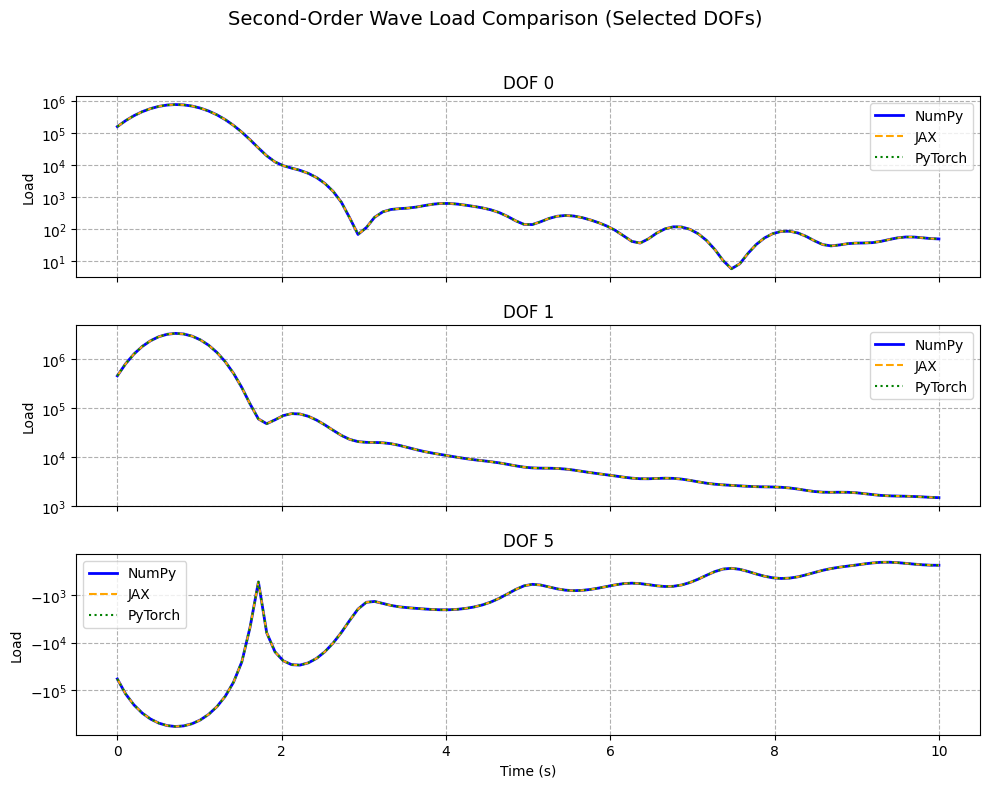

In [15]:
# Plot second order loads for DOFs 0, 1, and 5 with symlog scale.
dofs_so = [0, 1, 5]
fig_so, axes_so = plt.subplots(len(dofs_so), 1, figsize=(10, 8), sharex=True)
fig_so.suptitle("Second-Order Wave Load Comparison (Selected DOFs)", fontsize=14)
for idx, dof in enumerate(dofs_so):
    ax = axes_so[idx]
    ax.plot(time_vals, np_second_order_loads[:, dof], label="NumPy", color="blue", linewidth=2)
    ax.plot(time_vals, jax_second_order_loads_all[:, dof], label="JAX", linestyle="--", color="orange", linewidth=1.5)
    ax.plot(time_vals, torch_second_order_loads_all[:, dof], label="PyTorch", linestyle=":", color="green", linewidth=1.5)
    ax.set_title(f"DOF {dof}")
    ax.set_ylabel("Load")
    ax.set_yscale("symlog", linthresh=1e-2)  # Adjust linthresh as needed
    ax.legend()
    ax.grid(True, which="both", ls="--")
axes_so[-1].set_xlabel("Time (s)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
# =============================================================================
# Compare Total Wave Loads (First + Second Order) over time
# =============================================================================

# Use the same time_vals and eta_test arrays

# NumPy
np_wave_loads = np.array([numpy_wl_geo(t, eta_test_np) for t in time_vals])

# JAX
jax_wave_loads = np.array([np.array(jax_wave_load(t, eta_test_jax, jax_wl_geo))
                           for t in time_vals])

# PyTorch
torch_wave_loads_t = [torch_wl_geo(torch.tensor(t, dtype=torch.float32), eta_test_torch) for t in time_vals]
torch_wave_loads = np.array([load.detach().cpu().numpy() for load in torch_wave_loads_t])

print("\n--- Total Wave Loads Comparison over time ---")
print("NumPy Loads shape:", np_wave_loads.shape)
print("JAX Loads shape:", jax_wave_loads.shape)
print("PyTorch Loads shape:", torch_wave_loads.shape)

# Difference Stats
diff_total_jax = np.abs(np_wave_loads - jax_wave_loads)
diff_total_torch = np.abs(np_wave_loads - torch_wave_loads)
print("Max diff (NP vs JAX):", np.max(diff_total_jax), "Mean diff:", np.mean(diff_total_jax))
print("Max diff (NP vs Torch):", np.max(diff_total_torch), "Mean diff:", np.mean(diff_total_torch))


--- Total Wave Loads Comparison over time ---
NumPy Loads shape: (100, 6)
JAX Loads shape: (100, 6)
PyTorch Loads shape: (100, 6)
Max diff (NP vs JAX): 0.5132158054038882 Mean diff: 0.021902530408730705
Max diff (NP vs Torch): 0.580209715757519 Mean diff: 0.02394543921780279


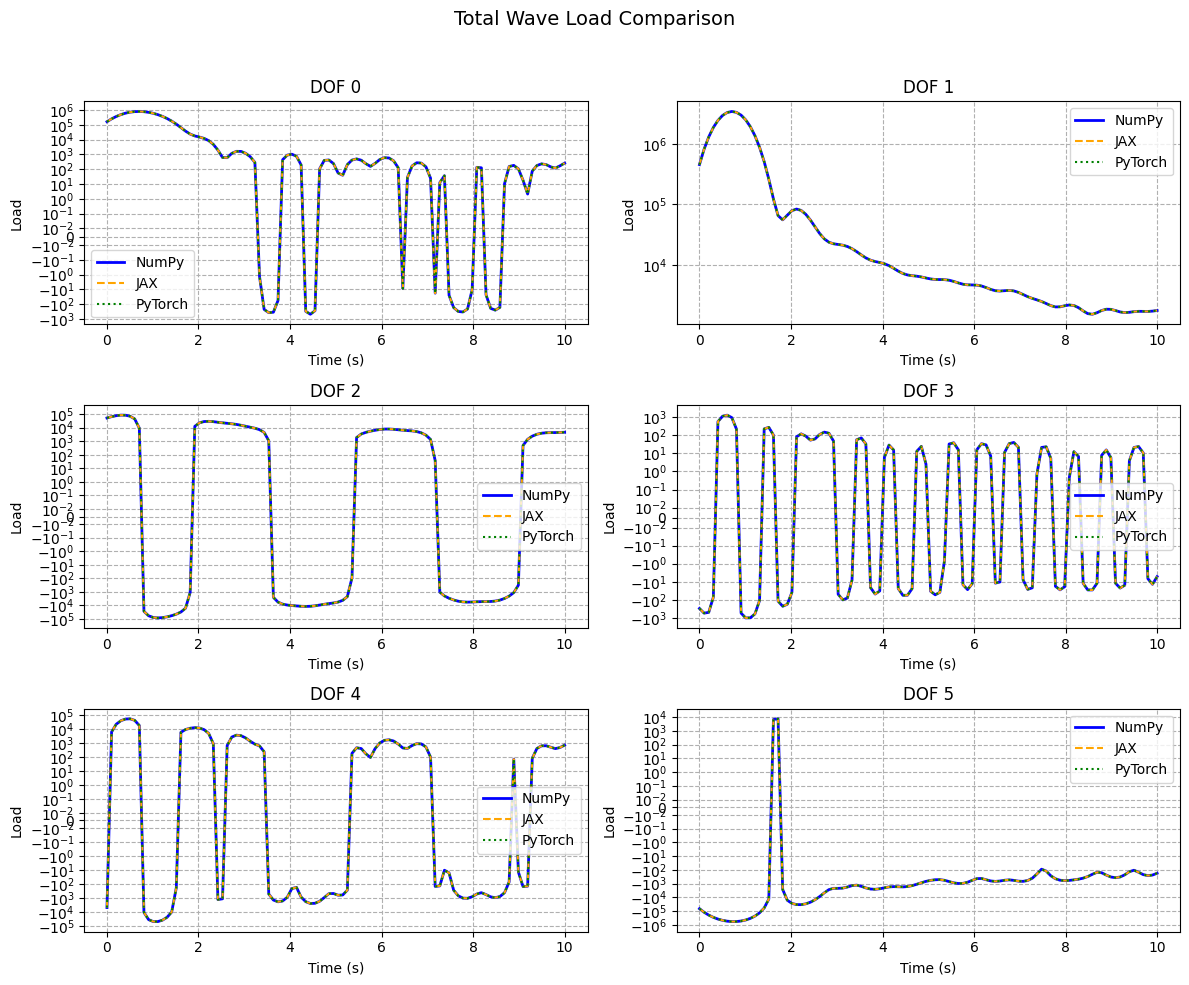

In [17]:
# plot the total wave loads with symlog scale
fig_total, axes_total = plt.subplots(3, 2, figsize=(12, 10))
fig_total.suptitle("Total Wave Load Comparison", fontsize=14)
for i in range(3):
    for j in range(2):
        dof_idx = i * 2 + j
        ax = axes_total[i, j]
        ax.plot(time_vals, np_wave_loads[:, dof_idx], label="NumPy", color='blue', linewidth=2)
        ax.plot(time_vals, jax_wave_loads[:, dof_idx], label="JAX", linestyle='--', color='orange', linewidth=1.5)
        ax.plot(time_vals, torch_wave_loads[:, dof_idx], label="PyTorch", linestyle=':', color='green', linewidth=1.5)
        ax.set_title(f"DOF {dof_idx}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Load")
        ax.set_yscale("symlog", linthresh=1e-2, linscale=0.5)
        ax.legend()
        ax.grid(True, which="both", ls="--")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()